# Generating Mock Data

Part 1 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook generates a realistic photometric survey catalog using a system of galaxy SED templates and photometric filters (included in this repository). It is based on a [similar notebook](https://github.com/ixkael/Photoz-tools) written by Boris Leistedt ([@ixkael](http://github.com/ixkael)).

## Setup

In [1]:
import sys # system commands
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
import pickle # saving data

# simulation code
import make_sim as sim 

%pylab
%matplotlib inline

import copy # copying functions

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# constant
c = 2.998e+18 # speed of light in A/s

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Defining the Underlying Galaxy Population

Simulating an underlying galaxy population has a few main parts:
- a collection of templates used to model the galaxy population
- a prior to characterize the underlying distribution

Here, we will utilize:
- **Templates**: 31 spectral energy distributions (SEDs) used to compute photometric redshifts (photo-z's) in [COSMOS](http://cosmos.astro.caltech.edu/) 30-band data since they span a decent range of color and have been shown to be successful. See [Ilbert et al. (2009)](http://adsabs.harvard.edu/abs/2009ApJ...690.1236I) for additional information.
- **Prior**: We break our prior into two parts: a magnitude prior $P(m)$ modeled as a power law based on [Leistedt et al. (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.460.4258L), and a type-redshift prior at fixed magnitude $P(t,z|m)$ from **BPZ** [v1.99](http://www.stsci.edu/~dcoe/BPZ/) (see [Benitez (2000)](http://adsabs.harvard.edu/abs/2000ApJ...536..571B) for additional information).

We first define our magnitude prior.

In [2]:
# define magnitude prior
def pmag(m, mlim): # magnitude grid and magnitude 5-sigma limit
    alpha, beta, off = 15.0, 2., 1. # coefficients
    p_imag = m**alpha*exp(-(m/(mlim-off))**beta)
    p_imag /= p_imag.sum()
    
    return p_imag

We note that can write the joint distribution $P(t,z,m)$ as 
$$ P(t,z,m) = P(z|t,m) P(t|m) P(m) \quad . $$
This allows us to draw from the joint distribution by sampling from each of the corresponding distributions from right to left. $P(m)$ is just our original magnitude prior, and $P(t|m)$ is the type-dependent fraction at a given magnitude.

In [3]:
# define the original BPZ prior
def bpz_prior(m, zgrid): # m = magnitude (~8140A), z = redshift
        
    # Formula: zm = zo + km*dm,  p(z|T,m) = z**a * exp(-(z/zm)**a)
    # coefficients from Table 1 of Benitez00
    a  = array([2.465,  1.806,  0.906])
    zo = array([0.431,  0.390,  0.0626])
    km = array([0.0913, 0.0636, 0.123])
    k_t= array([0.450,  0.147])

    # Fractions expected at m=20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = array([0.35, 0.5])

    # establish magnitude bounds
    mmin, mmax = 20., 32.
    m=clip(m, mmin, mmax) 
    dm = m - mmin # dmag
    
    # establish redshift bounds
    zmin, zmax = 0., 15.
    zmt = clip(zo+km*dm, zmin, zmax)
    zmt_at_a = zmt**a
    zt_at_a = power.outer(zgrid, a)
    
    # morphological fractions (0=Ell/S0, 1=Spiral, 2=Irr)
    f_t = zeros(3)
    f_t[:2] = fo_t * np.exp(-k_t*dm)
    f_t[2] = 1 - f_t.sum()
    
    # compute probability
    p_i = zt_at_a * exp(-clip(zt_at_a/zmt_at_a,0.,700.))
    p_i /= p_i.sum(axis=0)
    p_i *= f_t
    
    return p_i, f_t

# compute results over an (m,z) grid
mgrid = linspace(20., 32., 1000) # magnitude grid
zgrid = linspace(0., 15., 1000) # redshift grid

# define our N-D linteraly interpolated priors
bpz_arr = array([bpz_prior(m, zgrid)[0] for m in mgrid]) # priors at (m,z,t)
prior1 = interpolate.RegularGridInterpolator((mgrid, zgrid, [0,1,2]), bpz_arr) # P(t,z|m)
bpz_arr = array([bpz_prior(m, zgrid)[1] for m in mgrid]) # priors at (m,t)
prior2 = interpolate.RegularGridInterpolator((mgrid, [0,1,2]), bpz_arr) # P(t|m)

# define P(t,z|m)
def p_tz_m(t, z, m):
    m, z = clip(m, 20., 32.), clip(z, 0., 15.)
    return prior1((m, z, t))

# define P(t|m)
def p_t_m(t, m):
    m = clip(m, 20., 32.)
    return prior2((m, t))

Most of the functions we'll be using are part of the *make_sim.py* module and incorporated into the *survey* class. Let's load our templates into it.

In [4]:
survey = sim.survey() # intialize our survey

# load templates
survey.LoadTemplates('seds/COSMOS_MOD.list', path='seds/')

## Defining Our Survey: SDSS

To properly simulate observations, we will also need:
- a filter set we observe with
- associated imaging depths characterizing our survey

We will use 5-band $ugriz$ filters and depths from [SDSS](http://www.sdss.org/).

In [5]:
# load filters
survey.LoadFilters('filters/SDSS.list', mag_ref=3, path='filters/')

# initialize depths
depth_sdss = array([22.3, 23.3, 23.1, 22.3, 20.8]) # 5-sigma limiting magnitudes
survey.LoadDepth(depth_sdss, ones(5)*5)

Let's quickly plot these just to get a sense of how things look.

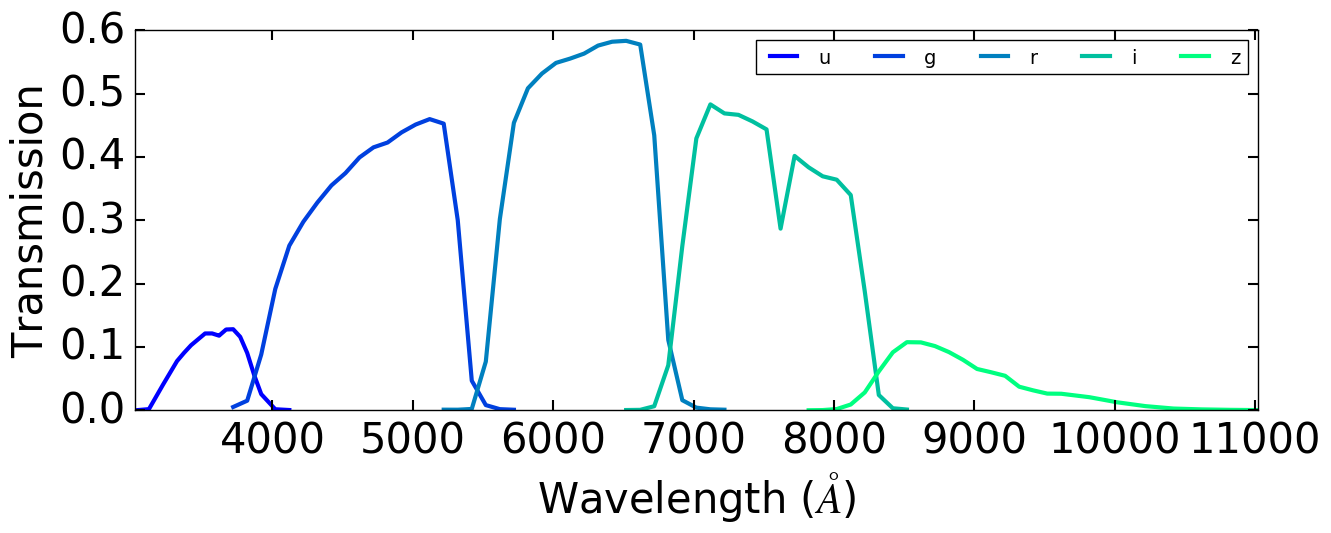

In [6]:
# plotting filters
fcolors = get_cmap('winter')(linspace(0, 1, survey.NFILTER)) # filter colors
xlow, xhigh = min(list(flatten(survey.fw))), max(list(flatten(survey.fw)))
figure(figsize=(14,6))
for i in xrange(survey.NFILTER):
    plot(survey.fw[i], survey.ft[i], lw=3, color=fcolors[i], label=survey.filters[i])
xlim([xlow, xhigh])
xlabel(r'Wavelength ($\AA$)')
ylabel('Transmission')
legend(ncol=survey.NFILTER, fontsize=14)
tight_layout()

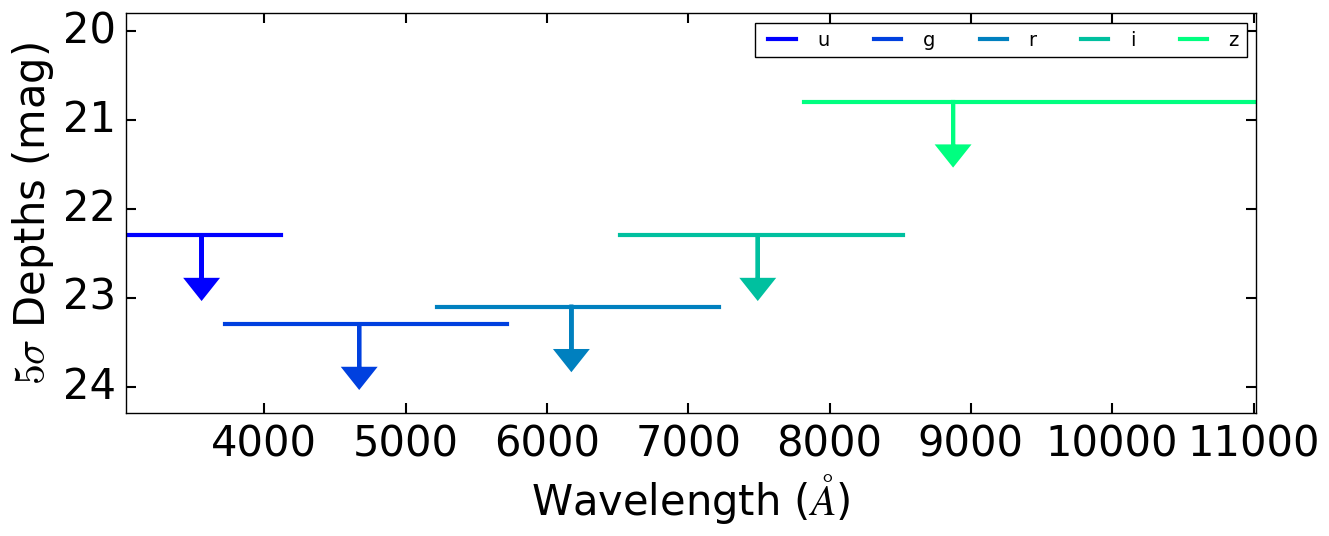

In [7]:
# plotting depths
figure(figsize=(14,6))
for i in xrange(survey.NFILTER):
    plot([min(survey.fw[i]), max(survey.fw[i])], [survey.MDEPTHS[i], survey.MDEPTHS[i]],
         lw=3, color=fcolors[i], label=survey.filters[i])
    arrow(survey.lambda_eff[i], survey.MDEPTHS[i], 0.0, 0.5, lw=3,
          fc=fcolors[i], ec=fcolors[i], head_width=200, head_length=0.2)
xlim([xlow, xhigh])
ylim([max(survey.MDEPTHS)+1.0, min(survey.MDEPTHS)-1.0])
xlabel(r'Wavelength ($\AA$)')
ylabel(r'$5\sigma$ Depths (mag)')
legend(ncol=survey.NFILTER, fontsize=14)
tight_layout()

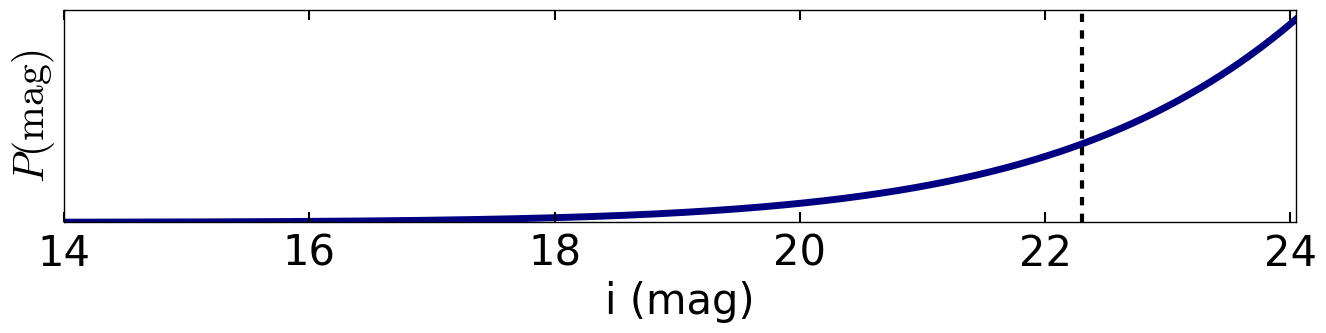

In [8]:
# plotting
figure(figsize=(14,4))
mdepth = survey.MDEPTHS[survey.mag_ref]
mhigh = mdepth + 2.5*log10(5)
mgrid = arange(14, mhigh, 0.01)
plot(mgrid, pmag(mgrid,mdepth), lw=5, color='navy')
axvline(mdepth, ls='--', lw=3, color='k')
xlabel(survey.filters[survey.mag_ref]+' (mag)')
xlim([None, mhigh])
ylabel(r'$P(\mathrm{mag})$')
yticks([])
tight_layout()

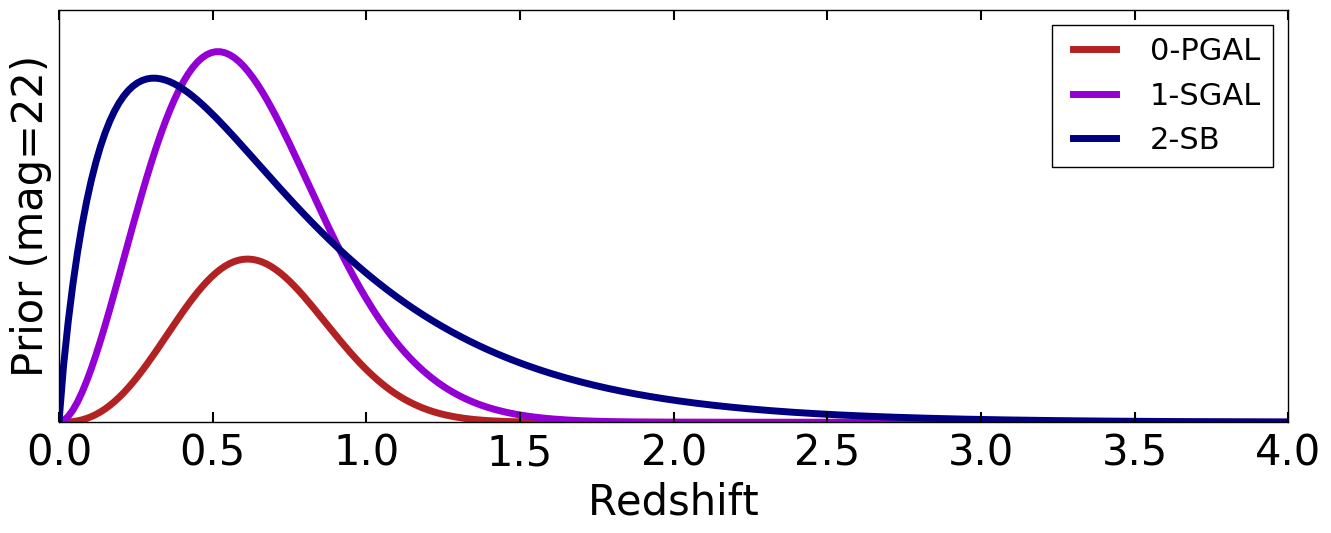

In [9]:
# plotting prior
mag=22
p_ztm = bpz_prior(mag, zgrid)[0] # p(z,m,t) evaluated over grid

# plotting
pcolors=['firebrick','darkviolet','navy'] # prior colors
figure(figsize=(14,6))
for i in xrange(len(survey.NTYPES)):
    plot(zgrid, p_ztm[:,i], lw=5, color=pcolors[i], label=survey.TYPES[i])
xlabel('Redshift')
xlim([0, 4])
ylabel('Prior (mag='+str(mag)+')')
yticks([])
legend(fontsize=22)
tight_layout()

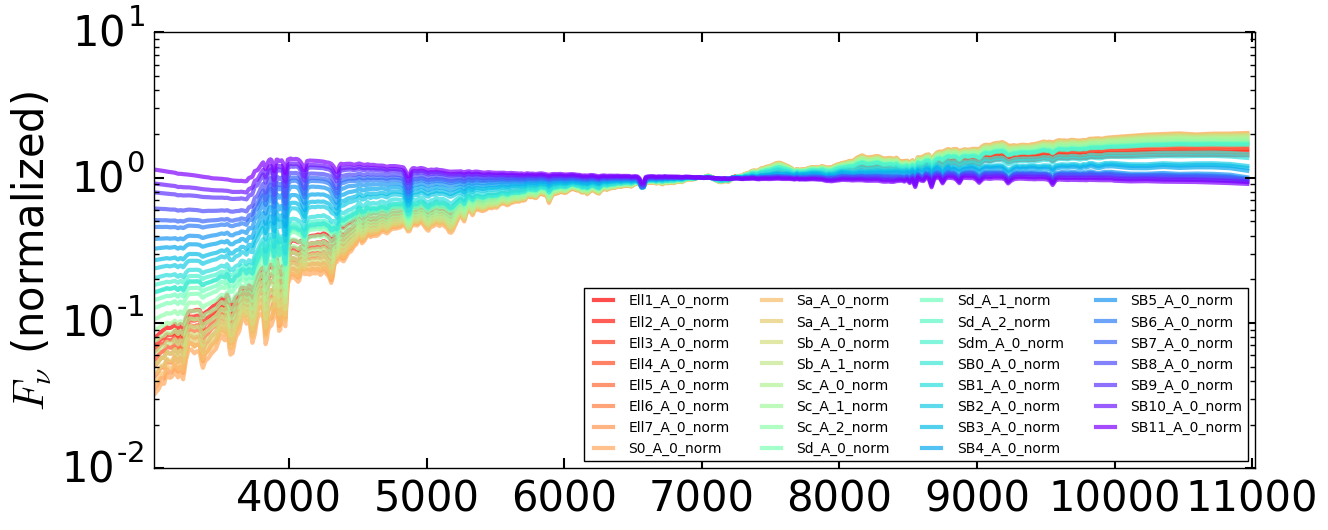

In [10]:
# plotting templates
tcolors=get_cmap('rainbow_r')(linspace(0,1,survey.NTEMPLATES)) # template colors
figure(figsize=(14,6))
for i in xrange(survey.NTEMPLATES):
    sel=(survey.tw[i]>xlow)&(survey.tw[i]<xhigh)
    semilogy(survey.tw[i][sel], survey.tfnu[i][sel], lw=3, color=tcolors[i], label=survey.templates[i], alpha=0.7)
xlim([xlow, xhigh])
ylabel(r'$F_{\nu}$ (normalized)')
legend(ncol=4, fontsize=10, loc=4)
tight_layout()

## Sampling Galaxy Populations

Now that we've set up our priors, we can easily generate samples from the overall distribution.

In [11]:
# draw samples for the given magnitude and redshift bounds
Ndraws = 500000
mbounds, zbounds = [14., 25.], [0., 6.]
types, redshifts, mags = survey.SamplePrior(p_tz_m, p_t_m, pmag, Ndraws, mbounds=mbounds, zbounds=zbounds)

Sampling mags...done!
Sampling types...done!
Sampling redshifts...done!


([], <a list of 0 Text yticklabel objects>)

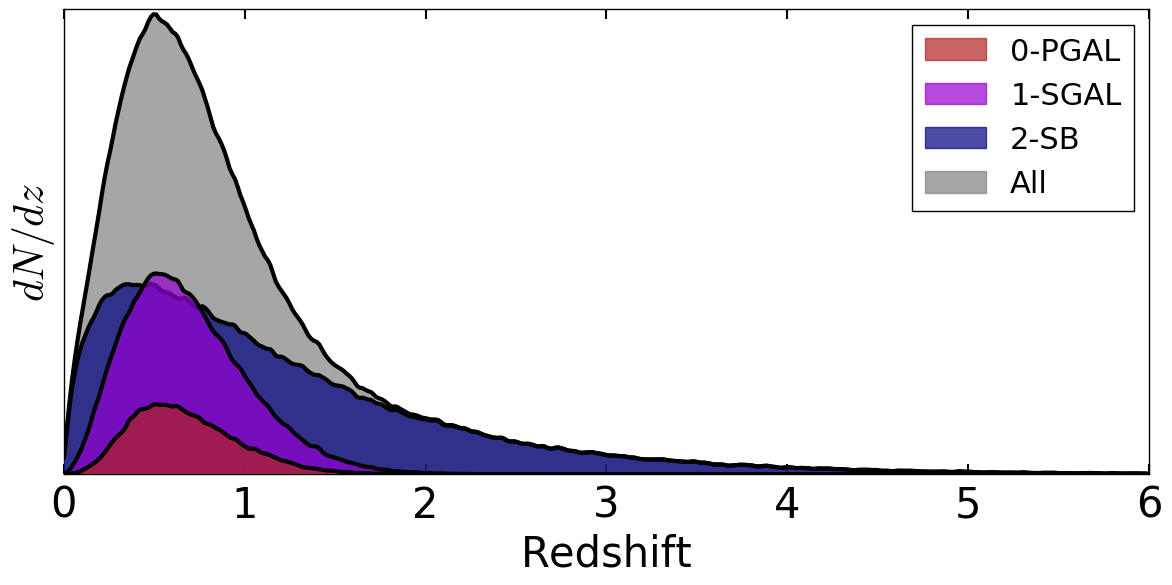

In [12]:
# plotting
figure(figsize=(14,6))
kde = KernelDensity(kernel='gaussian', bandwidth=zgrid[1]-zgrid[0]) # initialize kde
for i in arange(len(survey.NTYPES)):
    kde.fit(redshifts[types==i][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color='black', lw=3, zorder=10-i)
    fill_between(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color=pcolors[i], 
                 alpha=0.7, label=survey.TYPES[i], zorder=10-i)
kde.fit(redshifts[:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=3, zorder=10-i-1)
fill_between(zgrid, exp(log_dens), color='gray', alpha=0.7, label='All', zorder=10-i-1)
legend(fontsize=22)
xlabel('Redshift')
xlim(zbounds)
ylabel('$dN/dz$')
yticks([])

## Generating Mock Photometry

Now that we have a series of $P(t,z,m)$ draws, we have to convert those into actual fluxes. This involves picking a template (at random) within each sampled type $t$, redshifting our underlying templates by the sampled redshift $z$, integrating over the relevant filters, and then jittering the fluxes by the appropriate errors according to the sampled magnitude $m$. 

Note that we're ignoring the impact of both intra-galactic and inter-galactic extinction here to keep our mock data relatively simple. This omission isn't crucial to our purposes because we're just using these mock data as "proof of concept" test cases; we'll be applying our code to real data as well.

In [13]:
# sample 
background_std = 2. # fractional (i.e. factor of X) variation in background noise
phot, err, phot_obs = survey.SamplePhot(bg_lognorm_std=background_std)

### Sidenote: Selection Effects

Before we move on, we want to briefly illustrate the impact of selection effects on our survey. Let's assume we extract our photometry perfectly, but only do so if an object is detected at $>5\sigma$ in at least one band. This gives us the magnitude and redshift distributions shown below.

In [14]:
sel = (phot_obs/err > 5.).sum(axis=1) > 0
Nsel = sel.sum()

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log10


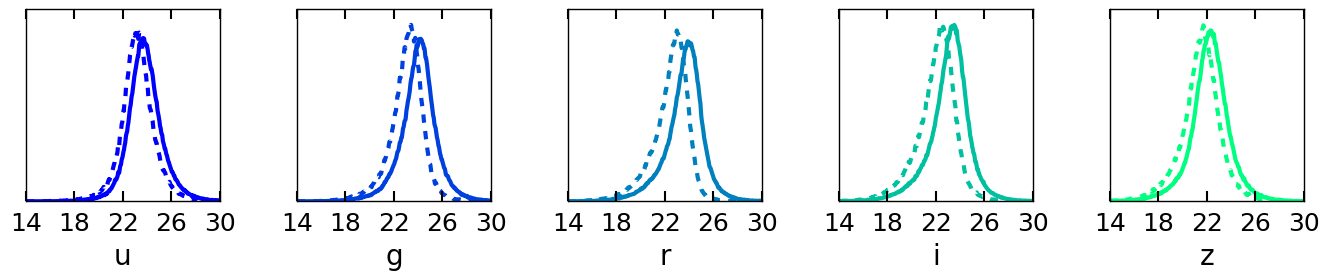

In [15]:
# plotting flux distribution
figure(figsize=(14,3.5))
kde = KernelDensity(kernel='gaussian', bandwidth=0.025) # initialize kde
mgrid=arange(14,30,0.01)
for i in xrange(survey.NFILTER):
    mag = -2.5*log10(phot_obs[:,i]) + 23.9
    subplot(1,survey.NFILTER,i+1)
    kde.fit(mag[isfinite(mag)][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(mgrid[:,None]) # return log(density)
    plot(mgrid, exp(log_dens), color=fcolors[i], lw=3)
    kde.fit(mag[isfinite(mag)&sel][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(mgrid[:,None]) # return log(density)
    plot(mgrid, exp(log_dens), color=fcolors[i], lw=3, ls='--')
    yticks([])
    xticks(arange(14,30.1,4),fontsize=18)
    xlabel(survey.filters[i],fontsize=20)
    tight_layout()

([], <a list of 0 Text yticklabel objects>)

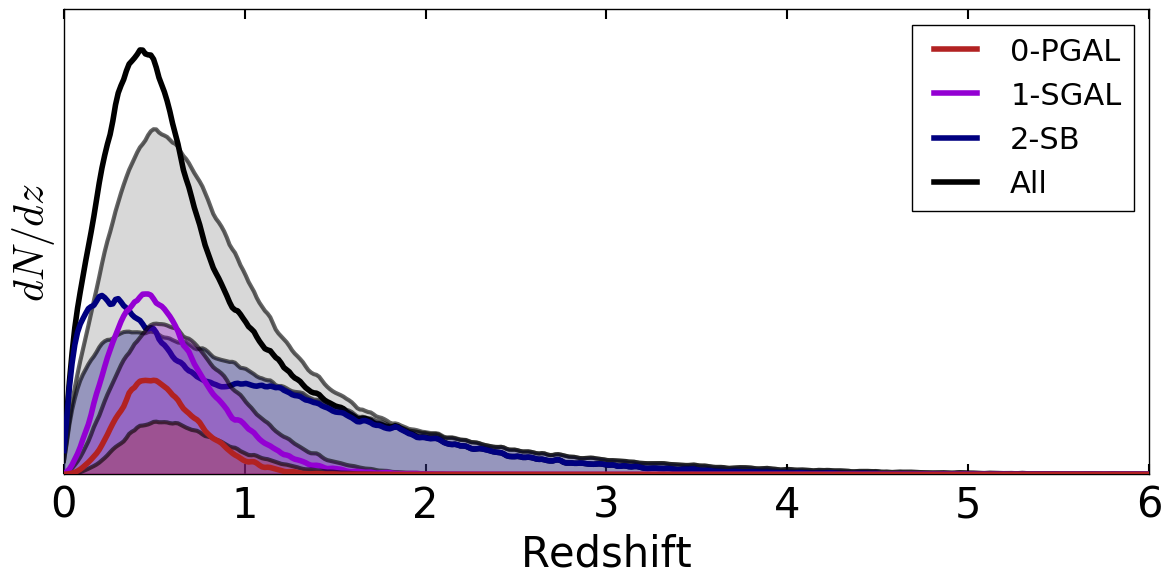

In [16]:
# plotting
figure(figsize=(14,6))
kde = KernelDensity(kernel='gaussian', bandwidth=zgrid[1]-zgrid[0]) # initialize kde
for i in arange(len(survey.NTYPES)):
    kde.fit(redshifts[types==i][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color='black', lw=3, zorder=10-i, alpha=0.6)
    fill_between(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color=pcolors[i], 
                 alpha=0.3, zorder=10-i)
    kde.fit(redshifts[(types==i)&sel][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum((types==i)&sel)/Nsel, color=pcolors[i], 
         lw=4, zorder=10-i, label=survey.TYPES[i])
kde.fit(redshifts[:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=3, zorder=10-i-1, alpha=0.6)
fill_between(zgrid, exp(log_dens), color='gray', alpha=0.3, zorder=10-i-1)
kde.fit(redshifts[sel][:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=4, zorder=10-i-1, label='All')
legend(fontsize=22)
xlabel('Redshift')
xlim(zbounds)
ylabel('$dN/dz$')
yticks([])

### Sidenote: Sampling Variation

Our mock data is a stochastic realization of the underlying relation between flux density and redshift, which will impact the quality of our inference in the next notebook when we transition from noiseless models to noisy training data. We visualize this below.

In [17]:
# construct error-free color-redshift tracts
tgrid, zgrid = arange(survey.NTEMPLATES), arange(0,6.01,0.01)
models = survey.GenModelGrid(templates=tgrid, redshifts=zgrid)

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log10
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in divide
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log10


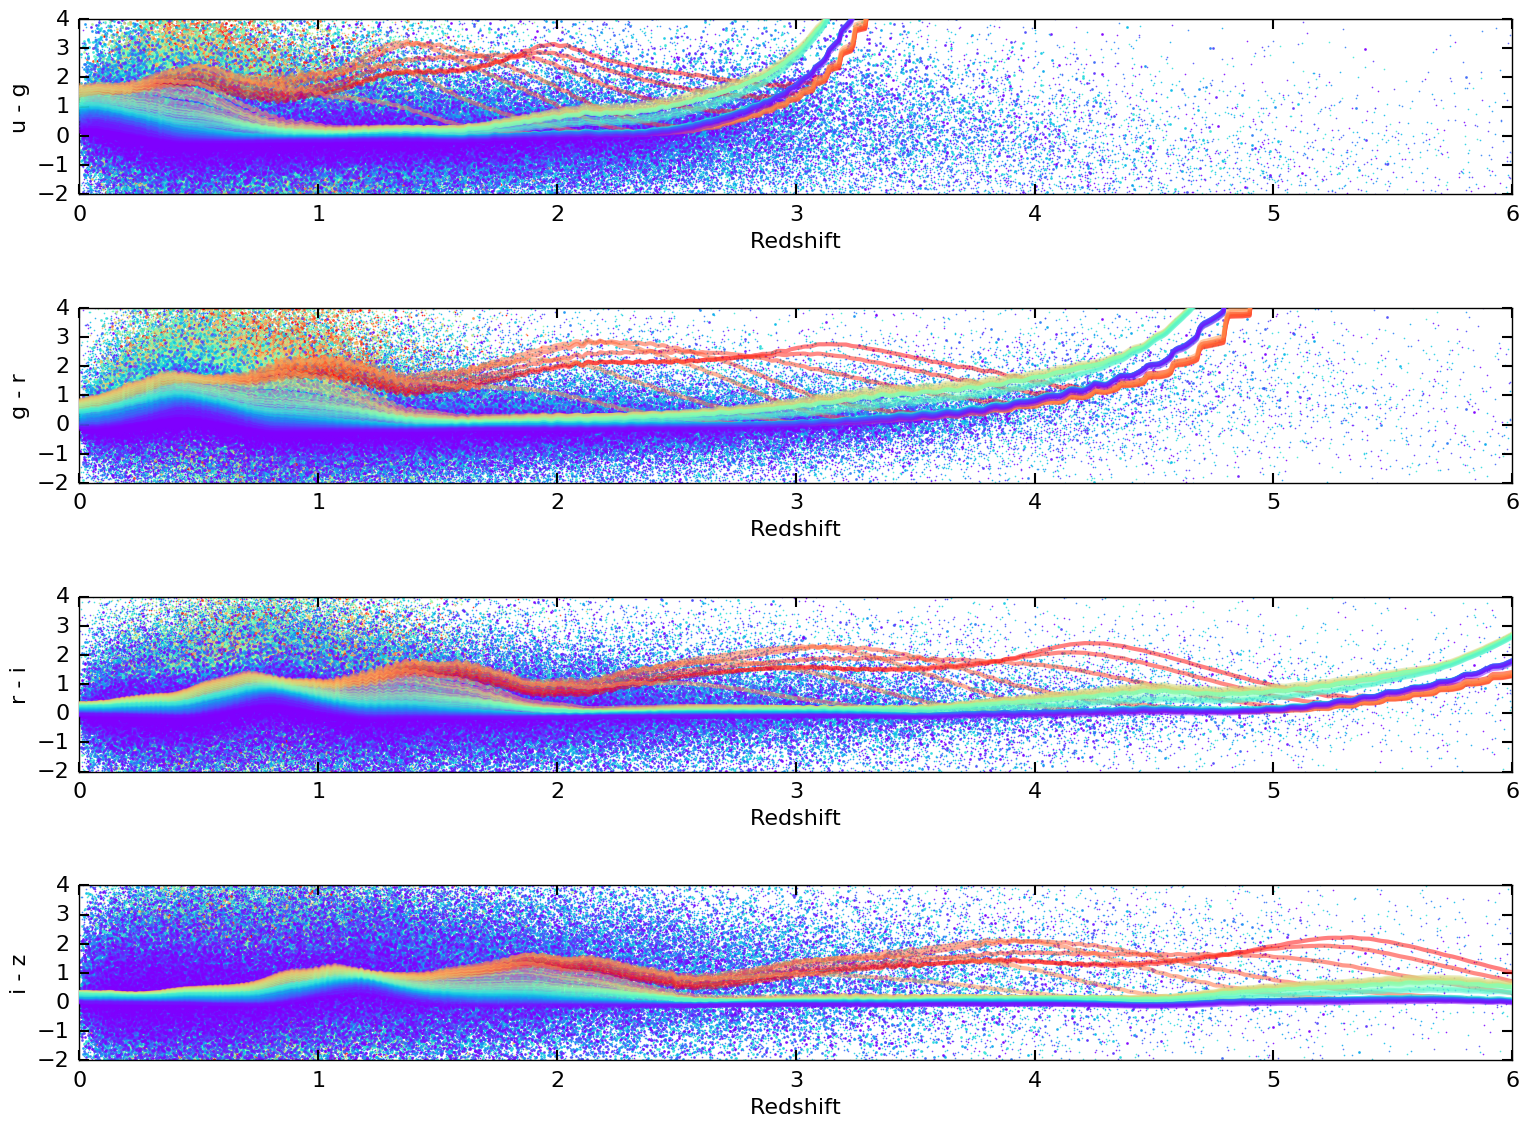

In [18]:
# plotting color-redshift tracts
templates = survey.samples_t
figure(figsize=(16,3*(survey.NFILTER-1)))
for i in xrange(survey.NFILTER-1):
    colors = -2.5 * log10(phot_obs[:,i] / phot_obs[:,i+1])
    subplot(survey.NFILTER-1, 1, i+1)
    for j in xrange(survey.NTEMPLATES):
        mcolors = -2.5 * log10(models[j][:,i] / models[j][:,i+1])
        tsel = (templates==j)
        plot(redshifts[tsel], colors[tsel], '.', markersize=1.5, color=tcolors[j], alpha=0.7, zorder=1)
        plot(redshifts[tsel&sel], colors[tsel&sel], '.', markersize=3, color=tcolors[j], alpha=0.7, zorder=2)
        plot(zgrid, mcolors, color=tcolors[j], lw=3, alpha=0.5, zorder=3)
    xticks(linspace(0,6,7), fontsize=16)
    xlabel('Redshift', fontsize=16)
    ylim([-2, 4])
    yticks(linspace(-2,4,7), fontsize=16)
    ylabel(survey.filters[i]+' - '+survey.filters[i+1], fontsize=16)
    tight_layout()

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log10
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in divide
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log10


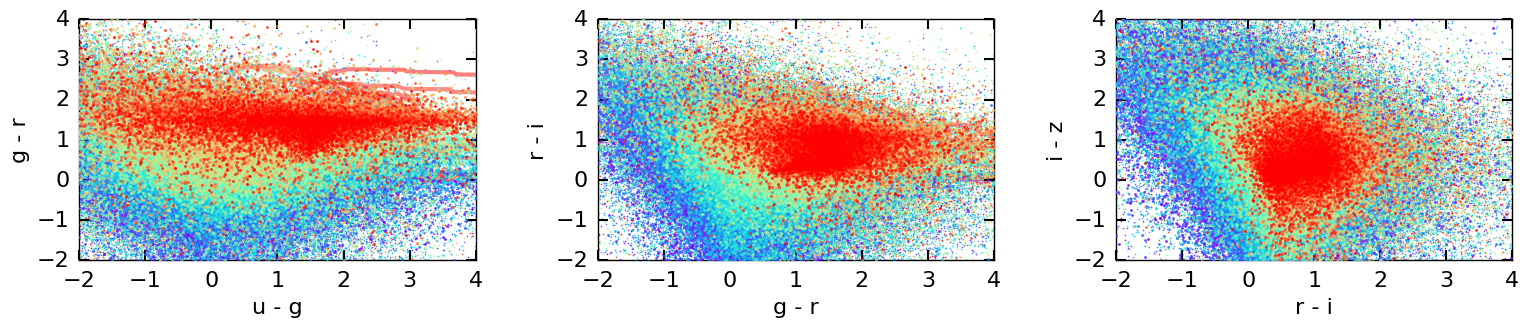

In [19]:
# plotting color-color distributions
figure(figsize=(16,4))
for i in xrange(survey.NFILTER-2):
    colors = -2.5 * log10(phot_obs[:,i] / phot_obs[:,i+1]), -2.5 * log10(phot_obs[:,i+1] / phot_obs[:,i+2])
    subplot(1, survey.NFILTER-2, i+1)
    for j in arange(survey.NTEMPLATES)[::-1]:
        mcolors = -2.5 * log10(models[j][:,i] / models[j][:,i+1]), -2.5 * log10(models[j][:,i+1] / models[j][:,i+2])
        tsel = (templates==j)
        plot(colors[0][tsel], colors[1][tsel], '.', markersize=1.5, color=tcolors[j], alpha=0.7, zorder=2)
        plot(colors[0][tsel&sel], colors[1][tsel&sel], '.', markersize=3, color=tcolors[j], alpha=0.7, zorder=3)
        plot(mcolors[0], mcolors[1], color=tcolors[j], lw=3, alpha=0.5, zorder=1)
    xlim([-2, 4])
    xticks(linspace(-2,4,7), fontsize=16)
    xlabel(survey.filters[i]+' - '+survey.filters[i+1], fontsize=16)
    ylim([-2, 4])
    yticks(linspace(-2,4,7), fontsize=16)
    ylabel(survey.filters[i+1]+' - '+survey.filters[i+2], fontsize=16)
    tight_layout()

Note that the model grid we generated to visualize these template-redshift tracts will be utilized in the next notebook.

## Wrapping up

We're now done, so let's dump our survey to disk.

In [20]:
pickle.dump(survey, open( "mock_sdss_cosmos_bpz.p", "wb" ), protocol=pickle.HIGHEST_PROTOCOL)

# Addendum: HSC Data

In addition to SDSS, we also construct a mock catalog designed around the 5-band $grizy$ [HSC SSP](http://hsc.mtk.nao.ac.jp/ssp/) survey.

In [21]:
survey = sim.survey() # intialize our survey

survey.LoadTemplates('seds/COSMOS_MOD.list', path='seds/') # load templates
survey.LoadFilters('filters/HSC.list', mag_ref=2, path='filters/') # load filters
depth_hsc = array([26.5, 26.1, 25.9, 25.1, 24.4]) # 5-sigma limiting magnitudes
survey.LoadDepth(depth_hsc, ones(5)*5) # load depths

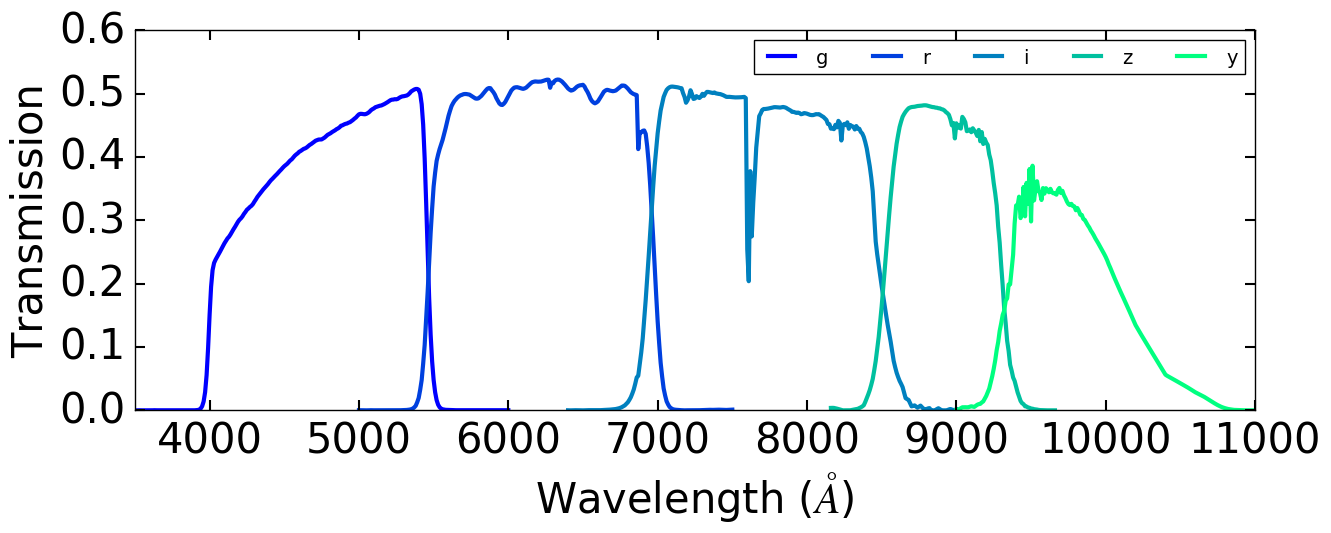

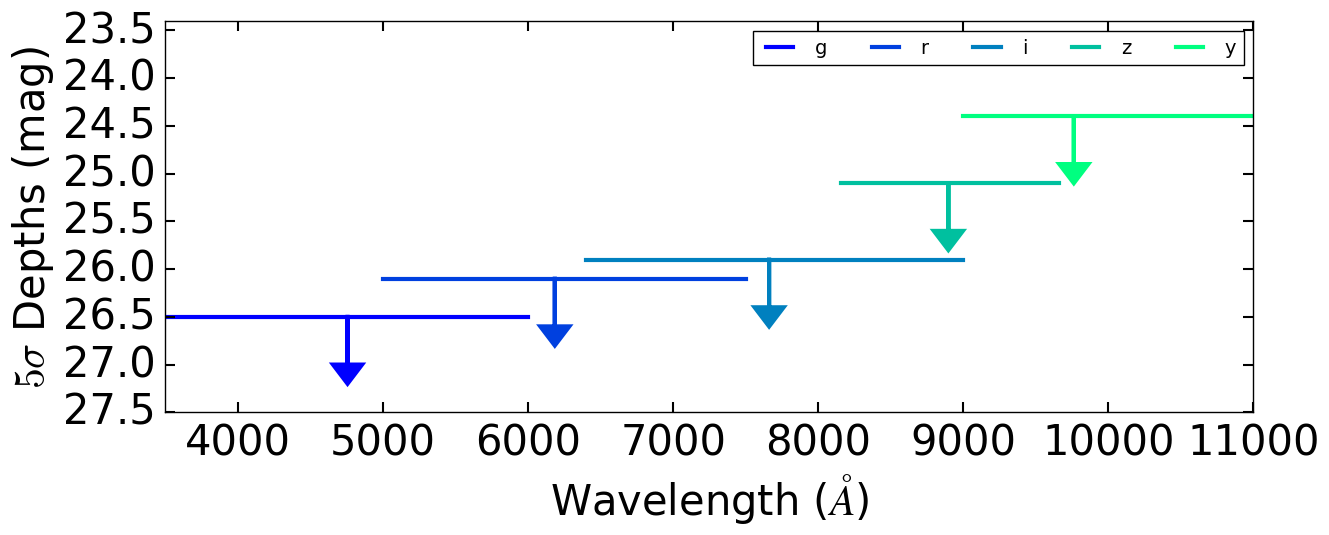

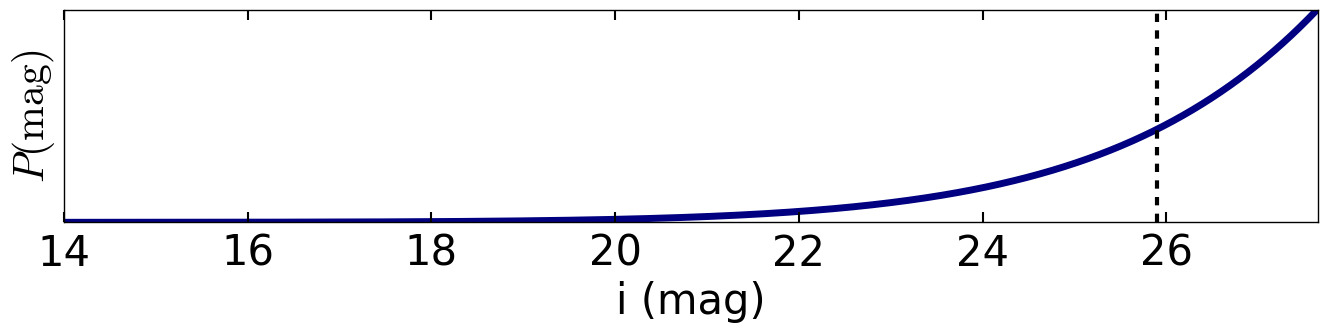

In [22]:
# plotting filters
fcolors = get_cmap('winter')(linspace(0, 1, survey.NFILTER)) # filter colors
xlow, xhigh = min(list(flatten(survey.fw))), max(list(flatten(survey.fw)))
figure(figsize=(14,6))
for i in xrange(survey.NFILTER):
    plot(survey.fw[i], survey.ft[i], lw=3, color=fcolors[i], label=survey.filters[i])
xlim([xlow, xhigh])
xlabel(r'Wavelength ($\AA$)')
ylabel('Transmission')
legend(ncol=survey.NFILTER, fontsize=14)
tight_layout()

# plotting depths
figure(figsize=(14,6))
for i in xrange(survey.NFILTER):
    plot([min(survey.fw[i]), max(survey.fw[i])], [survey.MDEPTHS[i], survey.MDEPTHS[i]],
         lw=3, color=fcolors[i], label=survey.filters[i])
    arrow(survey.lambda_eff[i], survey.MDEPTHS[i], 0.0, 0.5, lw=3,
          fc=fcolors[i], ec=fcolors[i], head_width=200, head_length=0.2)
xlim([xlow, xhigh])
ylim([max(survey.MDEPTHS)+1.0, min(survey.MDEPTHS)-1.0])
xlabel(r'Wavelength ($\AA$)')
ylabel(r'$5\sigma$ Depths (mag)')
legend(ncol=survey.NFILTER, fontsize=14)
tight_layout()

# plotting
figure(figsize=(14,4))
mdepth = survey.MDEPTHS[survey.mag_ref]
mhigh = mdepth + 2.5*log10(5)
mgrid = arange(14, mhigh, 0.01)
plot(mgrid, pmag(mgrid,mdepth), lw=5, color='navy')
axvline(mdepth, ls='--', lw=3, color='k')
xlabel(survey.filters[survey.mag_ref]+' (mag)')
xlim([None, mhigh])
ylabel(r'$P(\mathrm{mag})$')
yticks([])
tight_layout()

In [23]:
Ndraws = 500000
mbounds, zbounds = [14., 29.], [0., 8.]
types, redshifts, mags = survey.SamplePrior(p_tz_m, p_t_m, pmag, Ndraws, mbounds=mbounds, zbounds=zbounds)

Sampling mags...done!
Sampling types...done!
Sampling redshifts...done!


([], <a list of 0 Text yticklabel objects>)

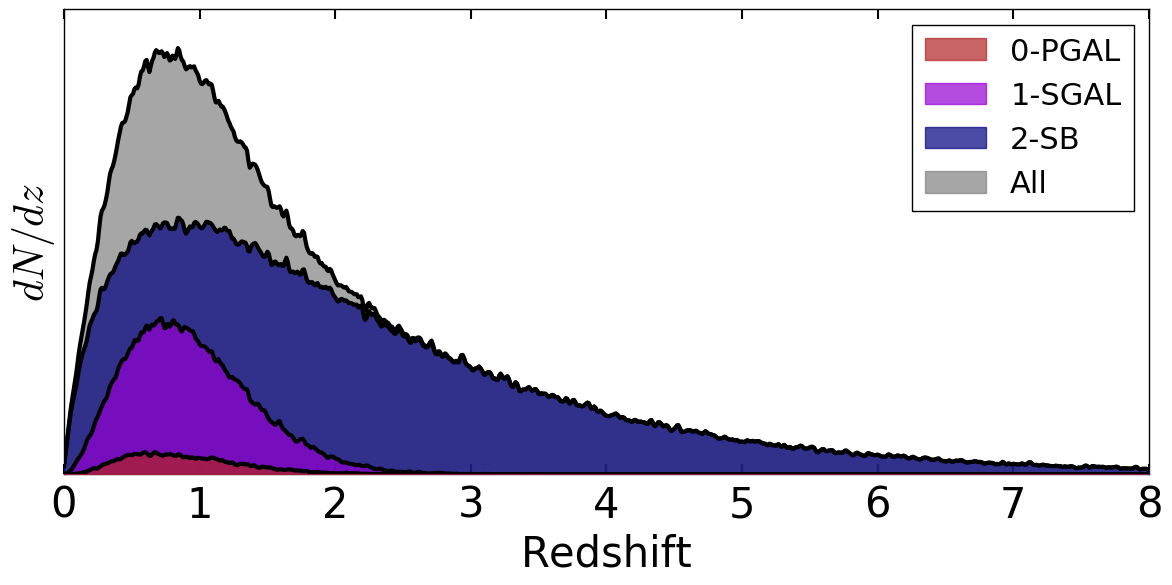

In [24]:
# plotting
figure(figsize=(14,6))
zgrid=arange(0,8.01,0.01)
kde = KernelDensity(kernel='gaussian', bandwidth=zgrid[1]-zgrid[0]) # initialize kde
for i in arange(len(survey.NTYPES)):
    kde.fit(redshifts[types==i][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color='black', lw=3, zorder=10-i)
    fill_between(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color=pcolors[i], 
                 alpha=0.7, label=survey.TYPES[i], zorder=10-i)
kde.fit(redshifts[:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=3, zorder=10-i-1)
fill_between(zgrid, exp(log_dens), color='gray', alpha=0.7, label='All', zorder=10-i-1)
legend(fontsize=22)
xlabel('Redshift')
xlim(zbounds)
ylabel('$dN/dz$')
yticks([])

In [25]:
background_std = 2. # fractional (i.e. factor of X) variation in background noise
phot, err, phot_obs = survey.SamplePhot(bg_lognorm_std=background_std)

sel = (phot_obs/err > 5.).sum(axis=1) > 0
Nsel = sel.sum()

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log10


([], <a list of 0 Text yticklabel objects>)

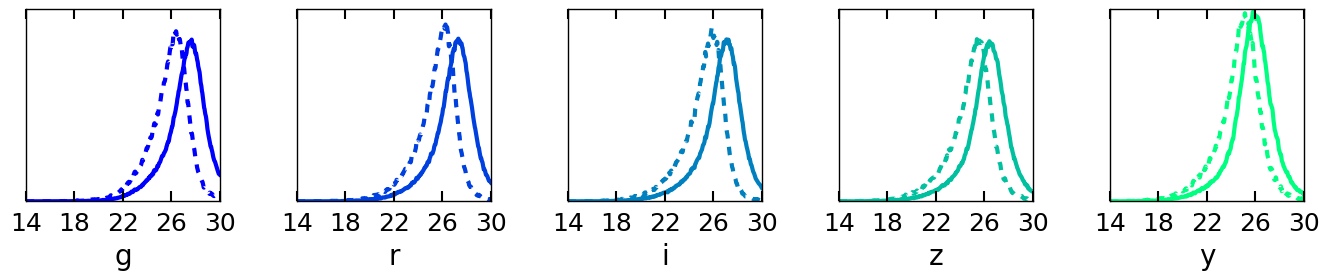

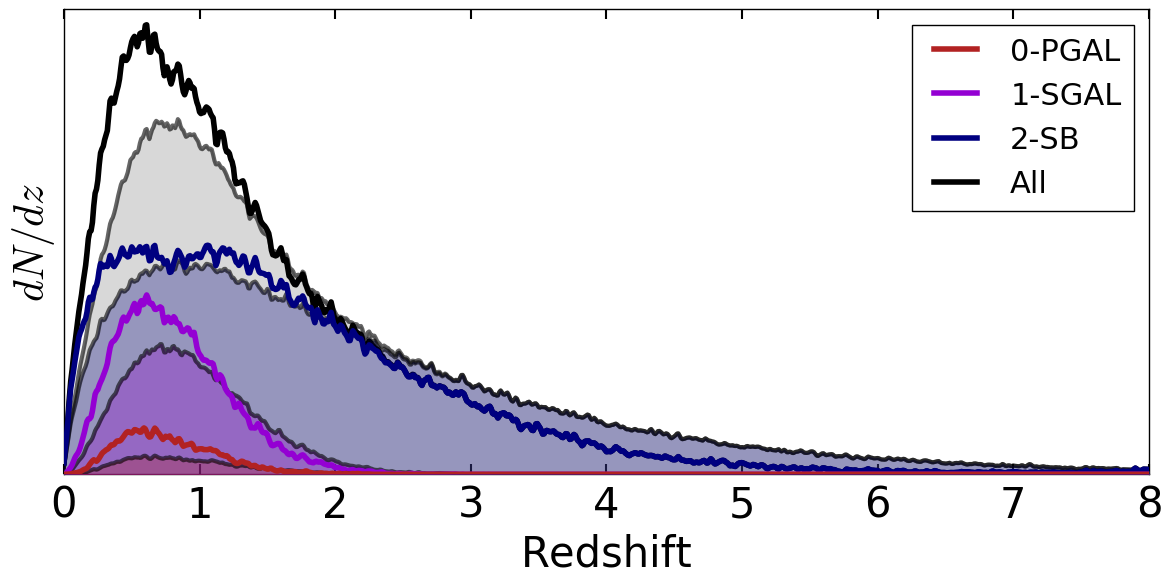

In [26]:
# plotting flux distribution
figure(figsize=(14,3.5))
kde = KernelDensity(kernel='gaussian', bandwidth=0.025) # initialize kde
mgrid=arange(14,30,0.01)
for i in xrange(survey.NFILTER):
    mag = -2.5*log10(phot_obs[:,i]) + 23.9
    subplot(1,survey.NFILTER,i+1)
    kde.fit(mag[isfinite(mag)][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(mgrid[:,None]) # return log(density)
    plot(mgrid, exp(log_dens), color=fcolors[i], lw=3)
    kde.fit(mag[isfinite(mag)&sel][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(mgrid[:,None]) # return log(density)
    plot(mgrid, exp(log_dens), color=fcolors[i], lw=3, ls='--')
    yticks([])
    xticks(arange(14,30.1,4),fontsize=18)
    xlabel(survey.filters[i],fontsize=20)
    tight_layout()
    
# plotting
figure(figsize=(14,6))
kde = KernelDensity(kernel='gaussian', bandwidth=zgrid[1]-zgrid[0]) # initialize kde
for i in arange(len(survey.NTYPES)):
    kde.fit(redshifts[types==i][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color='black', lw=3, zorder=10-i, alpha=0.6)
    fill_between(zgrid, exp(log_dens) * sum(types==i)/Ndraws, color=pcolors[i], 
                 alpha=0.3, zorder=10-i)
    kde.fit(redshifts[(types==i)&sel][:,None]) # derive the underlying estimator
    log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
    plot(zgrid, exp(log_dens) * sum((types==i)&sel)/Nsel, color=pcolors[i], 
         lw=4, zorder=10-i, label=survey.TYPES[i])
kde.fit(redshifts[:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=3, zorder=10-i-1, alpha=0.6)
fill_between(zgrid, exp(log_dens), color='gray', alpha=0.3, zorder=10-i-1)
kde.fit(redshifts[sel][:,None]) # derive the underlying estimator
log_dens = kde.score_samples(zgrid[:,None]) # return log(density)
plot(zgrid, exp(log_dens), color='black', lw=4, zorder=10-i-1, label='All')
legend(fontsize=22)
xlabel('Redshift')
xlim(zbounds)
ylabel('$dN/dz$')
yticks([])

In [27]:
# construct error-free color-redshift tracts
tgrid, zgrid = arange(survey.NTEMPLATES), arange(0,8.01,0.01)
models = survey.GenModelGrid(templates=tgrid, redshifts=zgrid)

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log10
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in divide
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log10
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: invalid value encountered in log10
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in divide
C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in log10


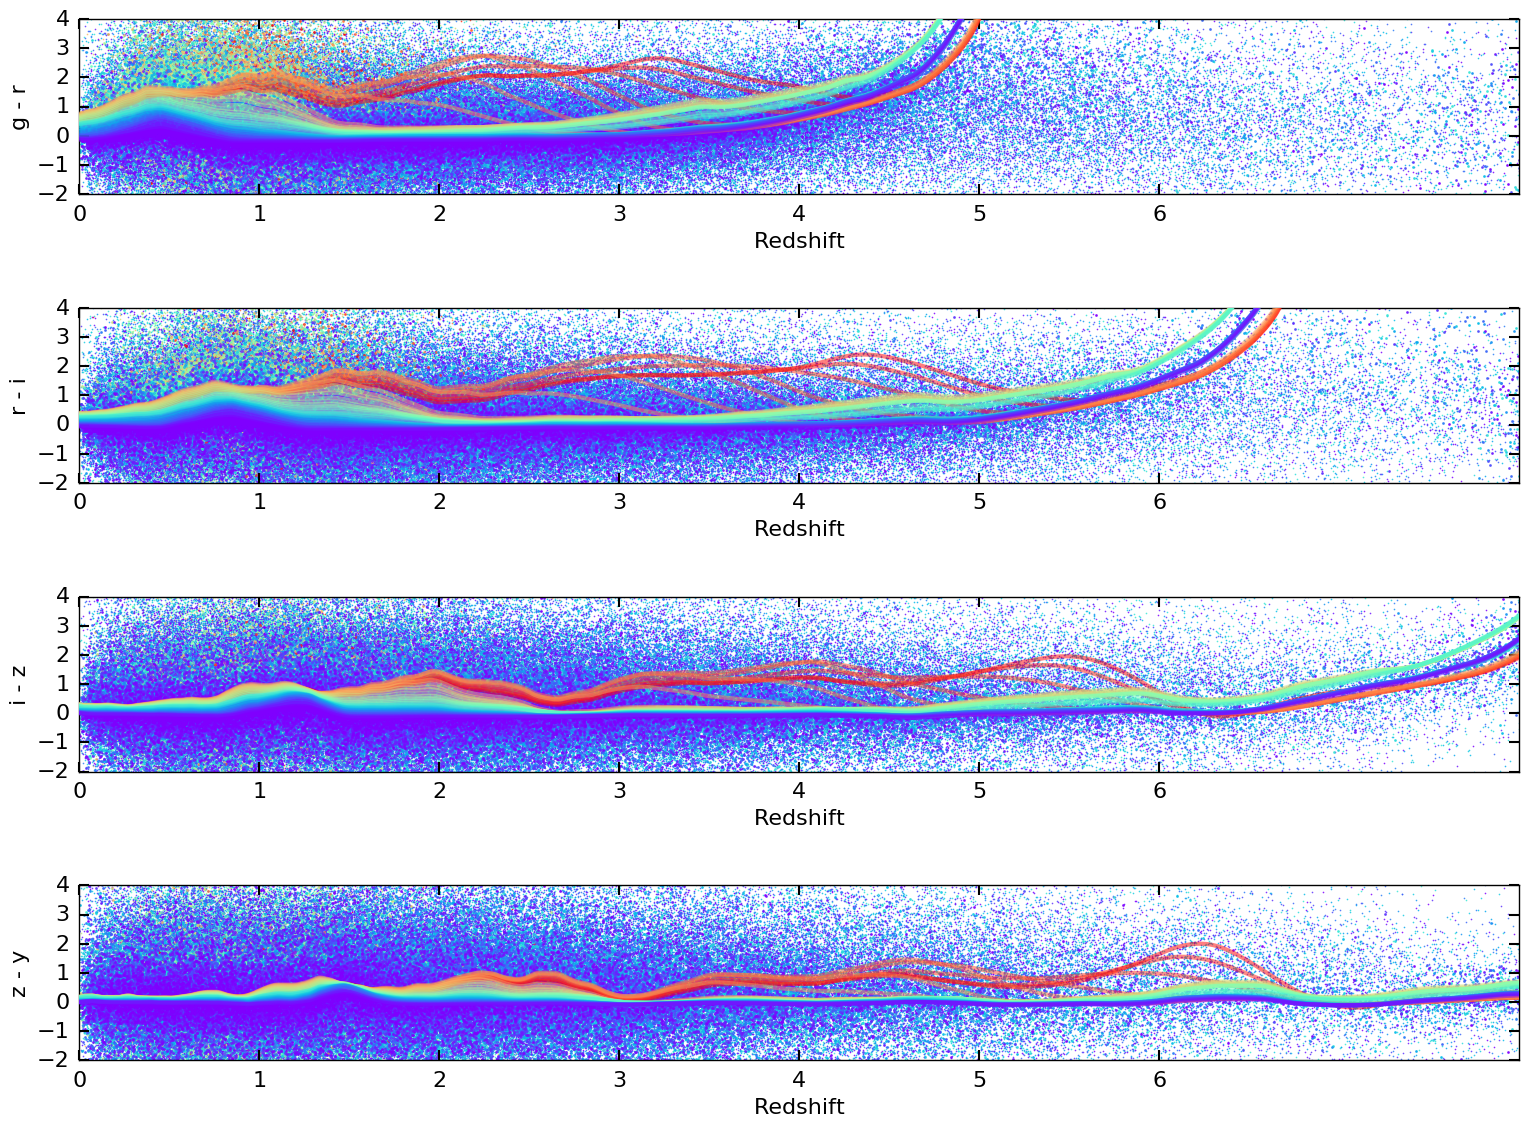

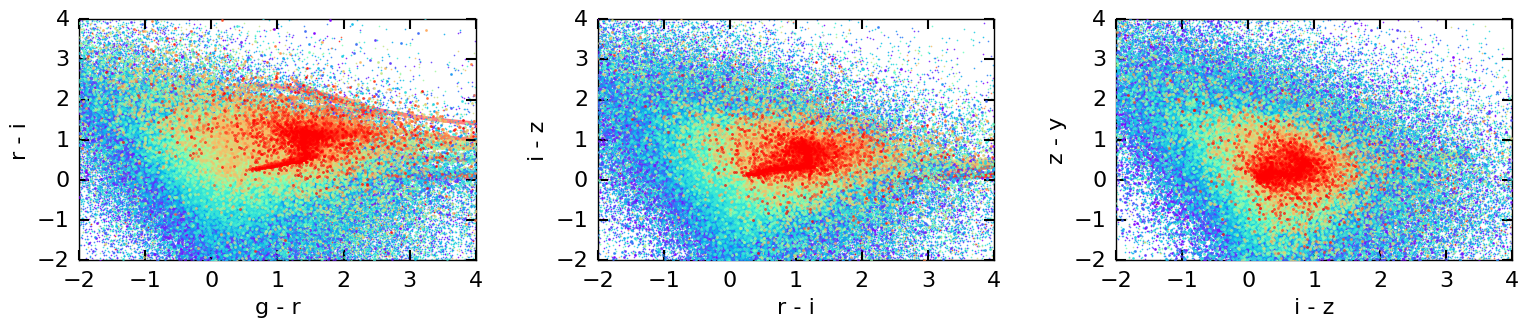

In [28]:
# plotting color-redshift tracts
templates = survey.samples_t
figure(figsize=(16,3*(survey.NFILTER-1)))
for i in xrange(survey.NFILTER-1):
    colors = -2.5 * log10(phot_obs[:,i] / phot_obs[:,i+1])
    subplot(survey.NFILTER-1, 1, i+1)
    for j in xrange(survey.NTEMPLATES):
        mcolors = -2.5 * log10(models[j][:,i] / models[j][:,i+1])
        tsel = (templates==j)
        plot(redshifts[tsel], colors[tsel], '.', markersize=1.5, color=tcolors[j], alpha=0.7, zorder=1)
        plot(redshifts[tsel&sel], colors[tsel&sel], '.', markersize=3, color=tcolors[j], alpha=0.7, zorder=2)
        plot(zgrid, mcolors, color=tcolors[j], lw=3, alpha=0.5, zorder=3)
    xticks(linspace(0,6,7), fontsize=16)
    xlabel('Redshift', fontsize=16)
    ylim([-2, 4])
    yticks(linspace(-2,4,7), fontsize=16)
    ylabel(survey.filters[i]+' - '+survey.filters[i+1], fontsize=16)
    tight_layout()
    
# plotting color-color distributions
figure(figsize=(16,4))
for i in xrange(survey.NFILTER-2):
    colors = -2.5 * log10(phot_obs[:,i] / phot_obs[:,i+1]), -2.5 * log10(phot_obs[:,i+1] / phot_obs[:,i+2])
    subplot(1, survey.NFILTER-2, i+1)
    for j in arange(survey.NTEMPLATES)[::-1]:
        mcolors = -2.5 * log10(models[j][:,i] / models[j][:,i+1]), -2.5 * log10(models[j][:,i+1] / models[j][:,i+2])
        tsel = (templates==j)
        plot(colors[0][tsel], colors[1][tsel], '.', markersize=1.5, color=tcolors[j], alpha=0.7, zorder=2)
        plot(colors[0][tsel&sel], colors[1][tsel&sel], '.', markersize=3, color=tcolors[j], alpha=0.7, zorder=3)
        plot(mcolors[0], mcolors[1], color=tcolors[j], lw=3, alpha=0.5, zorder=1)
    xlim([-2, 4])
    xticks(linspace(-2,4,7), fontsize=16)
    xlabel(survey.filters[i]+' - '+survey.filters[i+1], fontsize=16)
    ylim([-2, 4])
    yticks(linspace(-2,4,7), fontsize=16)
    ylabel(survey.filters[i+1]+' - '+survey.filters[i+2], fontsize=16)
    tight_layout()

In [29]:
pickle.dump(survey, open( "mock_hsc_cosmos_bpz.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL)